In [1]:
# -*- coding:utf-8 -*- 
from geopy.geocoders import Nominatim
import itchat
import pandas as pd
from collections import defaultdict

import warnings
warnings.simplefilter('ignore')

### Explore WeChat friends data with API
WeChat, similar to Fackbook, is the dominant multi-purpose social media app in China. A lot can be revealed by one's social circle. Here I explored mine just for fun and some details removed due to privacy concerns.

Goal:
1. While rooted in Beijing, I've spent years in New York, do I have more friends here or in hometown ?
2. It says there's a gender imbalance with more girls in New York and vice versa in the West coast, dose that also apply to my data ?

In [3]:
itchat.auto_login()

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as xxx


In [4]:
friends = itchat.get_friends(update=True)[0:]

### EDA

In [162]:
# get data 
text = dict()
for friend in friends[1:]:
    sex = friend['Sex']
    if sex == 1:
        text['male'] = text.get('male',0) + 1
    elif sex == 2:
        text['female'] = text.get('female',0) + 1
    else:
        text['other'] = text.get('other',0) + 1
total = len(friends[1:])

# sex percentage
print('male', "%.4f" % (text["male"] / total))
print('female', "%.4f" % (text["female"] / total))
print('other', "%.4f" % (text["other"] / total))

male 0.4698
female 0.4254
other 0.1048


In [164]:
# pie char in R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


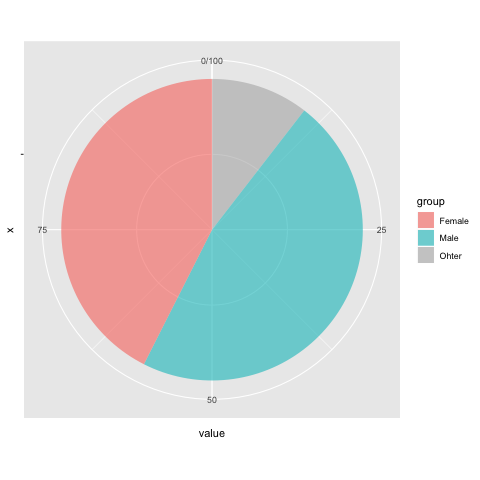

In [171]:
%%R
# pass python object df to R, needed in every chunk, in diff chunk with %load_ext ropy.ipython

library(ggplot2)
df <- data.frame(
    group = c("Male", "Female", "Ohter"),
    value = c(46.98, 42.54, 10.48)
)
ggplot(df, aes(x="", y=value, fill=group))+ 
    geom_bar(width = 1, stat = "identity",alpha=0.6)+ 
    coord_polar("y", start=0) + 
    scale_fill_manual(values=c( "#F8766D","#00BFC4",'grey70'))

In [18]:
df = pd.DataFrame(friends)
df['City'].unique()[:30]

array(['', 'New York', 'Santa Clara', 'Jersey City', '丰台', '海淀',
       'Los Angeles', 'Sunnyvale', 'San Diego', 'Boston', '朝阳',
       'Berkeley City', '深圳', 'Newark', '保定', '纽约', 'Bucks County',
       'San Francisco', 'United\xa0States', 'Bergen County',
       'New York City', 'South Burlington', 'Philadephia', '浦东新区',
       'Armonk', 'Balitmore', 'Pittsburgh', '青岛', 'New Haven', 'Columbia'],
      dtype=object)

In [32]:
# some geo locations are not at city level, for example '海淀' is a district of Beijing
# need to reduce redundance first, and convert all Chinese name to English, for example:
city_dic = {'海淀':'Beijing','东城':'Beijing'}

In [33]:
df.loc[df['Province']!=''].loc[df['City']=='']['Province'].unique()[:5]

array(['Tokyo', '北京', 'Auckland', 'New York', 'Augsburg'], dtype=object)

In [34]:
# some capital cities are labeled as province while missing city info, need a fix, for example:
province_city = ['Tokyo', 'Beijing''New York']

In [35]:
# now we can redue redundance 
df_city = df['City']
for i in range(len(df_city)):
    # map above cities with only province info
    if df['Province'][i] in province_city:        
        df_city[i] = df['Province'][i]
    # remove 'City' to reduce redundance 
    df_city[i] = df_city[i].replace(' City','')
    # reduce city redundance 
    if df_city[i] in city_dic.keys():
        df_city[i] = city_dic.get(df_city[i])
df['city_reduce'] = df_city 

In [62]:
# only major cities have population large enough to analyze by sex
major = ['Beijing','New York','San Francisco']
df_major = df.loc[df['city_reduce'].isin(major)]
df_major['Sex']=df_major['Sex'].astype(str)
major_city = df_major.groupby(['city_reduce','Sex']).count().iloc[:,:1].reset_index()
df1 = major_city.rename(index=str, columns={"Alias": "freq"})

In [77]:
# count population in all cities 
city_freq = defaultdict(int)
for city in df_city:
    city_freq[city] += 1
df2 = pd.DataFrame([[k]+[v] for k, v in city_freq.items()],columns=['city_reduce', 'freq'])
# assign sex=1 to population in all other cities
df2['Sex'] = '1'

In [193]:
city = pd.concat([df1.drop(df1[df1['Sex'] == '0'].index, inplace=True), df2.sort_values(by='freq', ascending=False).iloc[4:,]]) 
# remove sex=0 (unknown), df2.iloc[0]= missing city info


In [151]:
### Use geopy package to get geo longitude and latigude for map visualization

def get_geo(city):
    gps = Nominatim()
    location = gps.geocode(city)
    return([location.longitude,location.latitude])

In [144]:
city['geo'] = city['city_reduce'].map(get_geo)
city[['long','lat']] = pd.DataFrame(city.geo.values.tolist(), index= city.index)
city.to_csv('city_geo.txt',sep='\t',index=False)

### map visualization with R ggplot2

In [158]:
df3 = pd.read_csv('city_geo.txt',sep='\t')[['city','freq','long','lat','Sex']]
df3['Sex'] = df3['Sex'].str.replace('1','F')
df3['Sex'] = df3['Sex'].str.replace('2','M')

In [5]:
# geo map plot with R
%load_ext rpy2.ipython

'data.frame':	99338 obs. of  6 variables:
 $ long     : num  -69.9 -69.9 -69.9 -70 -70.1 ...
 $ lat      : num  12.5 12.4 12.4 12.5 12.5 ...
 $ group    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ order    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ region   : chr  "Aruba" "Aruba" "Aruba" "Aruba" ...
 $ subregion: chr  NA NA NA NA ...


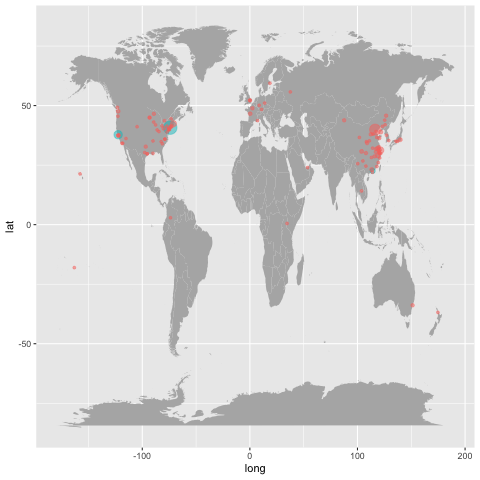

In [10]:
%%R -i df3

library(ggplot2)
library(maps)
library(repr)
mdat <- map_data('world')
str(mdat)

options(repr.plot.width=1, repr.plot.height=0.75)
ggplot() + 
    geom_polygon(dat=mdat, aes(long, lat, group=group), fill="grey70") +
    geom_point(data=df3,aes(x=long, y=lat, size=freq, colour=Sex),alpha = 0.5) +
    theme(legend.position="none")

#ggsave('wechat_map.pdf',width=8,height=4)

### Conclusion:

1. I have more friends in New York than in Beijing, possibly because I only started to use WeChat after I came here. Because geo location can be changed by users, some outlier locations such as places in Africa are likely jokes.  
2. I have slightly more Male friends than Female in both coasts, although I feel there are more girls in my social circle. Perhaps because I graduated from a university known for enginnering hence more alumni here.  